# Morphological Filters in Julia

In [23]:
using Images
using IJulia
using Interpolations
function resize(img)
    imresize(img, (300, 300), method=Interpolations.Constant())
end

resize (generic function with 1 method)

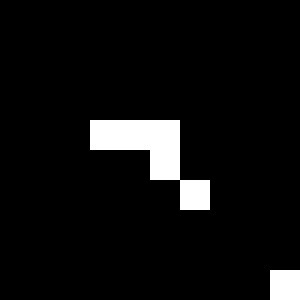

In [24]:
img1 = Gray.(zeros(10, 10))
img1[5, 5] = 1.0
img1[5, 4] = 1.0
img1[5, 6] = 1.0
img1[6, 6] = 1.0
img1[7, 7] = 1.0
img1[10, 10] = 1.0
resize(img1)

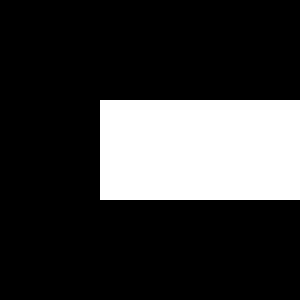

In [25]:
kernel1 = Gray.([0.0 0.0 0.0; 0.0 1.0 1.0; 0.0 0.0 0.0])
resize(kernel1)


In [26]:

# Dilution Function
function dilution_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] == 1.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        if image[y, x] == 1.0
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = 1.0
                        end
                    end
                end
            end


        end
    end

    return result_image[2:end-1, 2:end-1]
end

dilution_binary (generic function with 1 method)

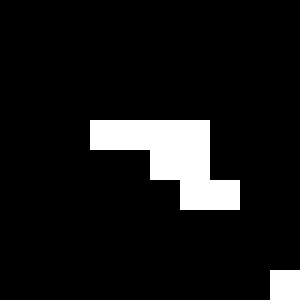

In [27]:
resize(dilution_binary(img1, kernel1))

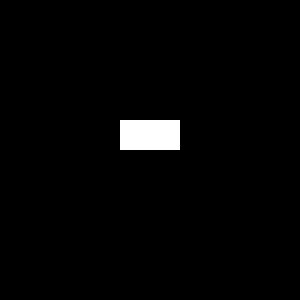

In [28]:
invert(image::Matrix{Gray{Float64}}) = image .* -1 .+ 1

function erosion_binary(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_binary(invert(image), kernel))
end

resize(erosion_binary(img1, kernel1))


In [29]:

# Dilution Function for continous images.
# Here in the kernel values of 99 are ignored
function dilution_continous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    y_kernel_dim, x_kernel_dim = size(kernel) # eg. 3,3
    focus_y, focus_x = ceil(Int, y_kernel_dim / 2), ceil(Int, x_kernel_dim / 2) # eg. 2,2
    height, width = size(image) # eg. 10,10
    result_image = Gray.(zeros(height + y_kernel_dim - 1, width + x_kernel_dim - 1)) #eg. 12,12
    for j in 1:y_kernel_dim
        for i in 1:x_kernel_dim
            if kernel[j, i] != 99.0
                # the kernel pixel is active
                offset_y, offset_x = j - focus_y, i - focus_x
                for y in 1:height
                    for x in 1:width
                        prev_cell = result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1]
                        maybe_next_cell = kernel[j, i] * image[y, x]
                        if maybe_next_cell > prev_cell
                            result_image[y+offset_y+focus_y-1, x+offset_x+focus_x-1] = maybe_next_cell
                        end
                    end
                end
            end


        end
    end
    return result_image[2:end-1, 2:end-1]
end


function erosion_continous(image::Matrix{Gray{Float64}}, kernel::Matrix{Gray{Float64}})
    invert(dilution_continous(invert(image), kernel))
end

erosion_continous (generic function with 1 method)

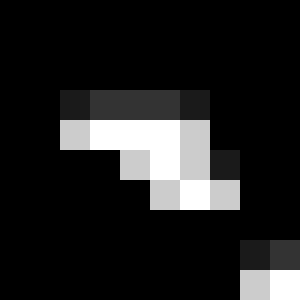

In [30]:
kernel_c = Gray.([
    0.1 0.2 0.1
    0.8 1.0 0.8
    99.0 99.0 99.0])

resize(dilution_continous(img1, kernel_c))

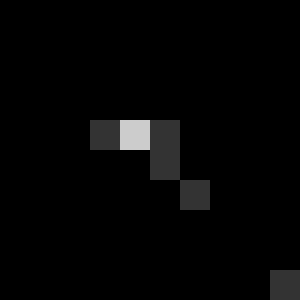

In [31]:
resize(erosion_continous(img1, kernel_c))

# trying some nicer images and kernels

input images

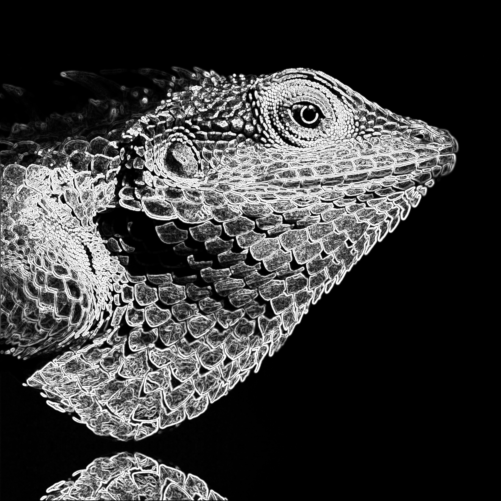

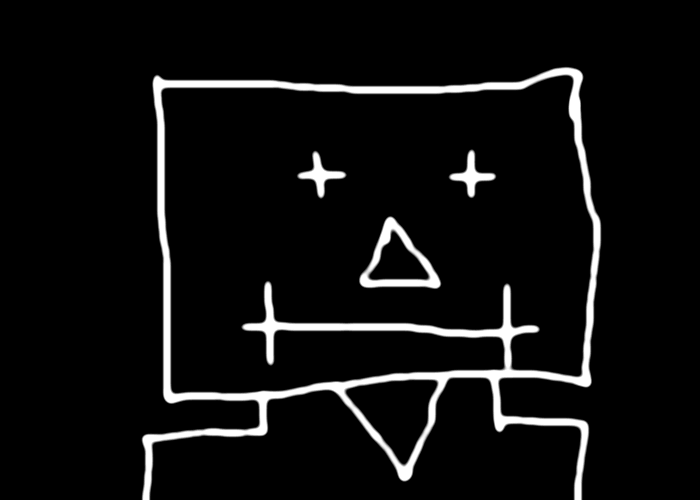

lizard image has shape: (4000, 4000)robot image has shape: (500, 700)

In [32]:
img_lizard = Gray{Float64}.(load("./images/input/lizard_sobel_4000.jpg"))
print("lizard image has shape: $(size(img_lizard))")
IJulia.display(img_lizard)
img_robot = Gray{Float64}.(load("./images/input/robot.png"))
print("robot image has shape: $(size(img_robot))")
IJulia.display(img_robot)

load some interesting kernels

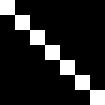

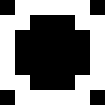

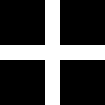

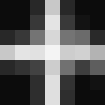

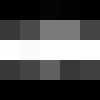

In [33]:
kernels = map(1:5) do x 
    Gray{Float64}.(load("./images/input/kernel$(x).png"))
end

for k in kernels
    IJulia.display(k)
end

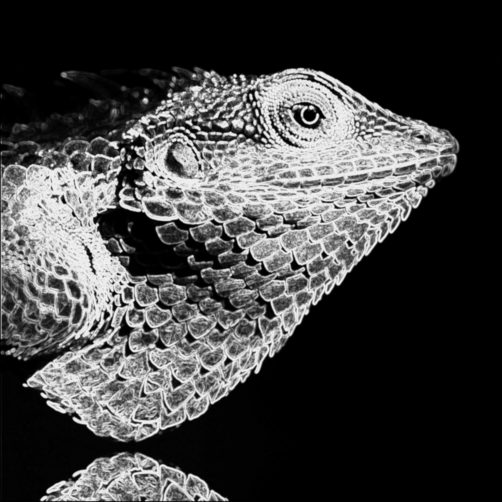

In [43]:
dilution_continous(img_lizard, kernels[4])

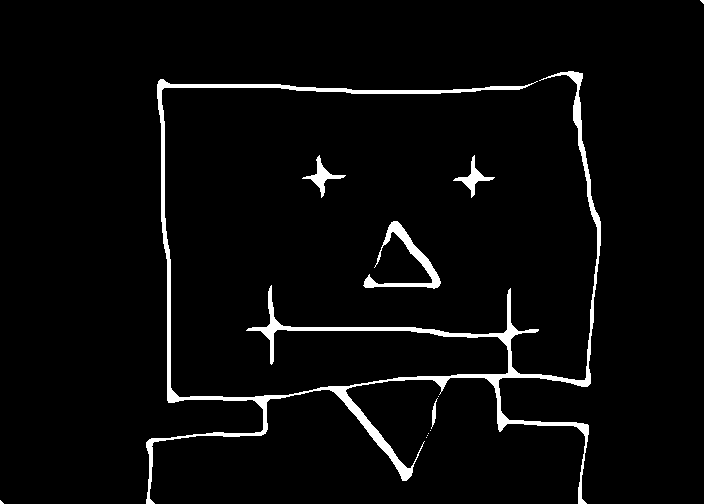

In [41]:
erosion_binary(img_robot, kernels[1])

2x erosion on these areas

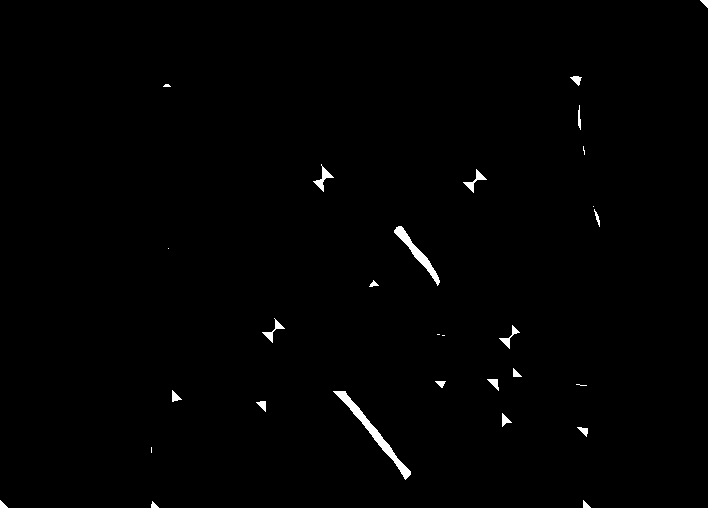

In [39]:
erosion_binary(erosion_binary(img_robot, kernels[1]), kernels[1])

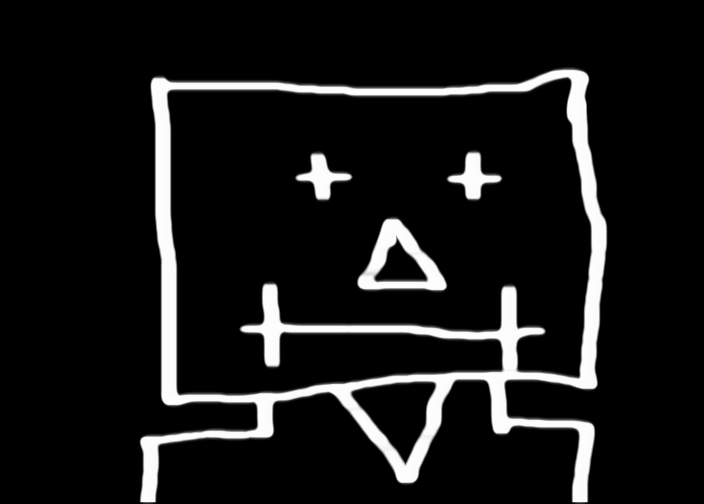

In [54]:
dilution_continous(dilution_continous(img_robot, kernels[5]), kernels[5])

use the cross shaped filter to find corners:

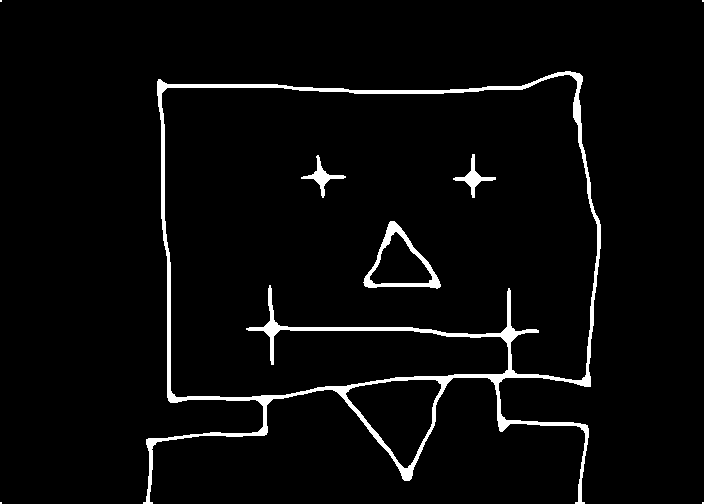

In [57]:
erosion_binary(img_robot, kernels[3])

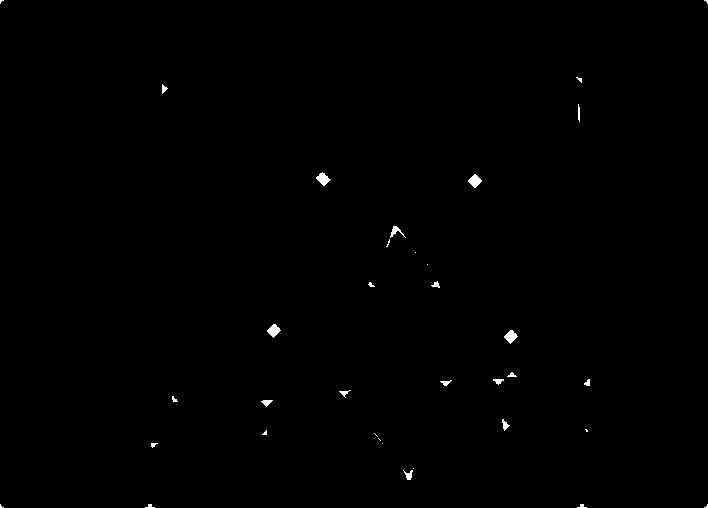

In [58]:
erosion_binary(erosion_binary(img_robot, kernels[3]), kernels[3])

# Runtime Analysis

3x3 filter:

binary 3x3 kernel with 2 active points

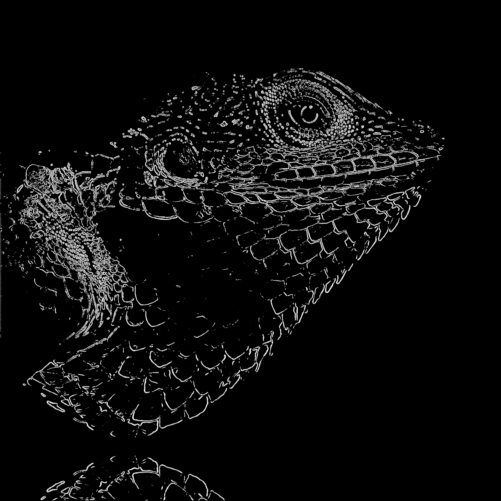

  0.766358 seconds (6 allocations: 366.455 MiB, 31.07% gc time)


binary 3x3 kernel with 9 active points

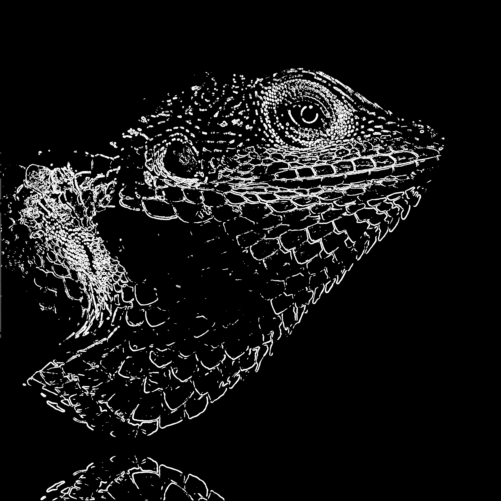

  2.198301 seconds (6 allocations: 366.455 MiB, 2.07% gc time)

In [63]:
kernel1 = Gray.([0.0 0.0 0.0; 0.0 1.0 1.0; 0.0 0.0 0.0])
println("binary 3x3 kernel with 2 active points")
@time i = dilution_binary(img_lizard, kernel1)
IJulia.display(i)

kernel2 = Gray.(ones((3,3)))
println("binary 3x3 kernel with 9 active points")
@time i = dilution_binary(img_lizard, kernel2)
IJulia.display(i)

continous dilution 3x3 kernel with 2 active points


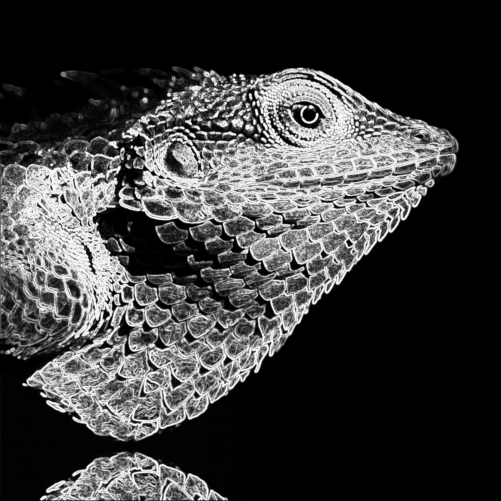

  4.342493 seconds (6 allocations: 366.455 MiB, 1.09% gc time)


continous  dilution 3x3 kernel with 9 active points


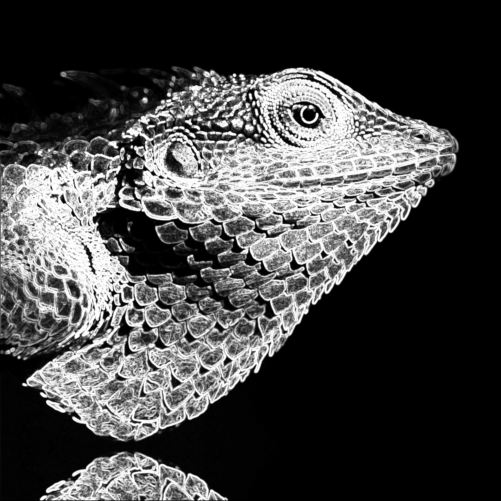

  4.054581 seconds (6 allocations: 366.455 MiB)


continous erosion 3x3 kernel with 2 active points

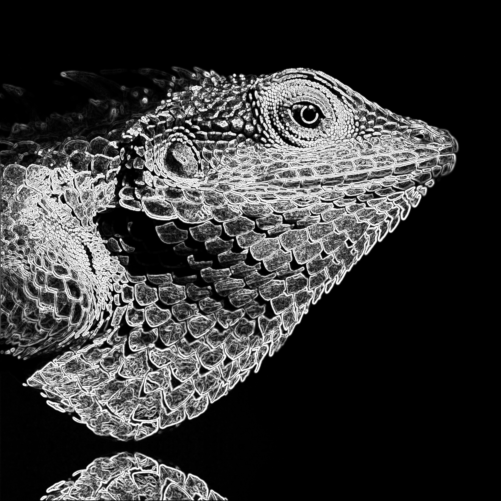


  2.874356 seconds (10 allocations: 610.596 MiB, 7.90% gc time)


continous erosion 3x3 kernel with 9 active points


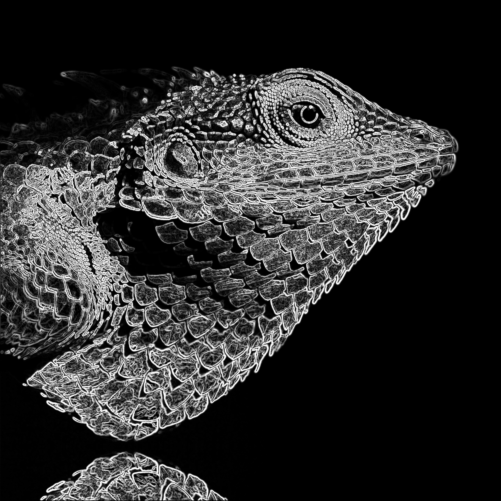

  2.523731 seconds (10 allocations: 610.596 MiB, 1.24% gc time)


In [65]:
println("continous dilution 3x3 kernel with 2 active points")
@time i = dilution_continous(img_lizard, kernel1)
IJulia.display(i)

println("continous  dilution 3x3 kernel with 9 active points")
@time i = dilution_continous(img_lizard, kernel2)
IJulia.display(i)

println("continous erosion 3x3 kernel with 2 active points")
@time i = erosion_continous(img_lizard, kernel1)
IJulia.display(i)

println("continous erosion 3x3 kernel with 9 active points")
@time i = erosion_continous(img_lizard, kernel2)
IJulia.display(i)

effect of kernel size

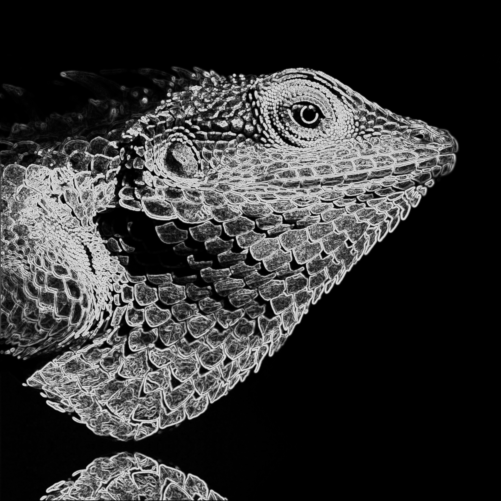

  4.193569 seconds (6 allocations: 366.455 MiB, 6.59% gc time)


continous 3x3 kernel


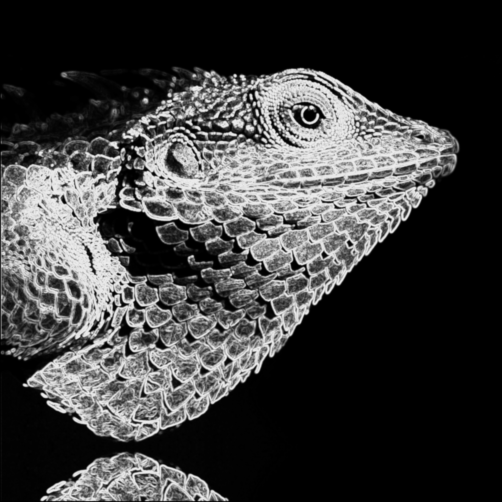

  7.839968 seconds (6 allocations: 366.822 MiB, 0.43% gc time)


continous 5x5 kernel

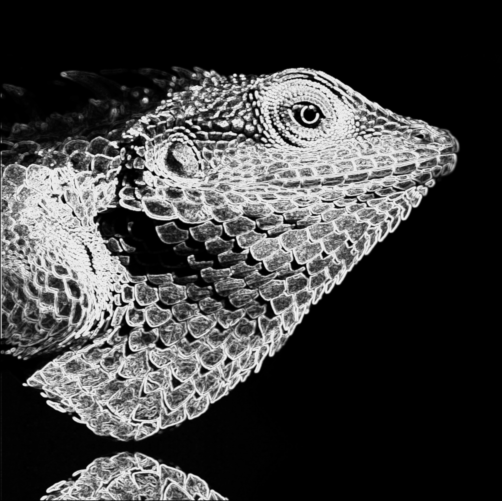


  4.953671 seconds (6 allocations: 367.005 MiB, 0.77% gc time)
continous 2x10 kernel

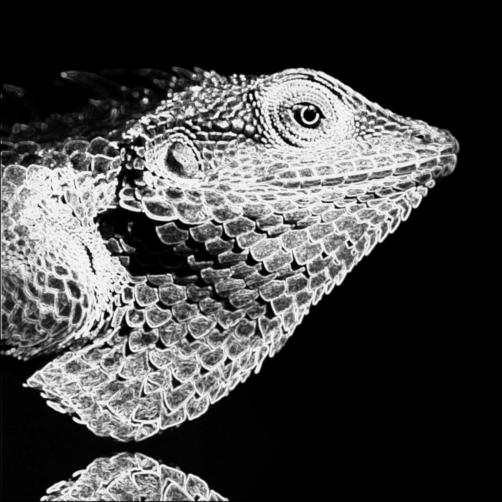


 13.352882 seconds (6 allocations: 367.188 MiB)
continous 7x7 kernel


In [71]:
kernel3x3 = Gray.(rand(3,3))
kernel5x5 = Gray.(rand(5,5))
kernel2x10 = Gray.(rand(2,10))
kernel7x7 = Gray.(rand(7,7))

@time i = dilution_continous(img_lizard, kernel3x3)
IJulia.display(i)

println("continous 3x3 kernel")

@time i = dilution_continous(img_lizard, kernel5x5)
IJulia.display(i)

println("continous 5x5 kernel")

@time i = dilution_continous(img_lizard, kernel2x10)
IJulia.display(i)

println("continous 2x10 kernel")

@time i = dilution_continous(img_lizard, kernel7x7)
IJulia.display(i)

println("continous 7x7 kernel")